[*********************100%%**********************]  503 of 503 completed


1 Failed download:
['EQR']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-11-21 00:00:00 -> 2023-11-19)')


AttributeError: 'NoneType' object has no attribute 'iloc'

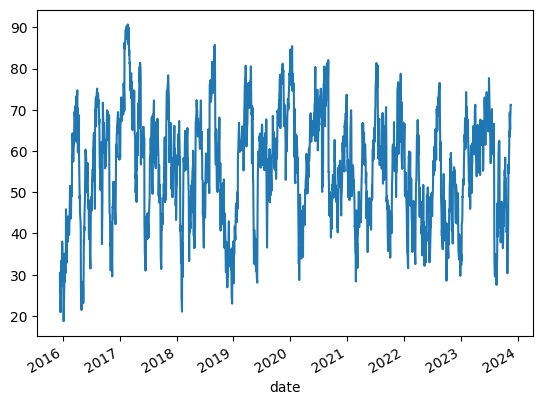

In [10]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')


sp500 = pd.read_html ('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbols_list = sp500['Symbol'].unique().tolist()
# symbols_list
end_date = '2023-11-19'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()
df.index.names = ['date','ticker']
#df
df.columns = df.columns.str.lower()
#df
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
# garman klass volatility: estimator that incorporates open, low, high, and close prices of a security
# 
# df
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, Length=20))
# df
# relative strength index: is a momentum oscillator
# measures the speed and change of price movements.
# RSI oscillates between zero and 100.
# Traditionally RSI is considered overbought when above 70
# and oversold when below 30
# RSI also used to identify general trends
df.xs('AAPL', level=1)['rsi'].plot()
# rsi or relative strength index of Apple
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
df
# Bollinger Bands : consists of a middle band (which is a moving average)
# These upper and lower bands are set above and below the moving average 
# by a certain number of standard deviations of price, thus incorporating volatility

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
#df
# ATR is very useful for stops or entry triggers, signaling changes in volatility.

# def compute_macd(close):
#     macd = pandas_ta.macd(close=close, Length=20).iloc[:,0]
#     return macd.sub(macd.mean()).div(macd.std())

# df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
# df
# df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
# df

# 